In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
from PIL import Image
from hcmus.core import appconfig
from hcmus.lbs import LabelStudioConnector

In [38]:
lsb_connector = LabelStudioConnector(
    url=appconfig.LABEL_STUDIO_URL,
    api_key=appconfig.LABEL_STUDIO_API_KEY,
    project_id=appconfig.LABEL_STUDIO_PROJECT_MAPPING["template"],
    temp_dir=appconfig.LABEL_STUDIO_TEMP_DIR
)

In [39]:
lsb_connector.get_total_tasks()

3

In [40]:
tasks = lsb_connector.get_tasks()
dataset = lsb_connector.download_dataset(tasks)

2025-05-04 15:37:59.852 | WARNING  | hcmus.lbs._label_studio_connector:get_tasks:121 - Page size is too large, only 3 tasks available.
Loading tasks: 100%|██████████| 1/1 [00:00<00:00, 14.63it/s]
2025-05-04 15:37:59.922 | INFO     | hcmus.lbs._label_studio_connector:download_dataset:48 - No labels input, auto extract 1 labels.


In [41]:
background_img = dataset[2].get("image")
background_boxes = dataset[2].get("target").get("boxes")

In [42]:
import cv2
import numpy as np

def rotate_image_and_boxes(image, boxes, angle):
    """
    Rotates an image and bounding boxes.

    Parameters:
        image (np.ndarray): The image to rotate.
        boxes (list of tuples): List of (x_min, y_min, x_max, y_max) boxes.
        angle (float): Rotation angle in degrees (positive: counter-clockwise).

    Returns:
        rotated_image (np.ndarray)
        rotated_boxes (list of tuples)
    """
    h, w = image.shape[:2]
    center = (w // 2, h // 2)

    # Rotate image
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    new_w = int(h * sin + w * cos)
    new_h = int(h * cos + w * sin)

    # Adjust rotation matrix to take into account translation
    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]

    rotated_image = cv2.warpAffine(image, M, (new_w, new_h))

    # Rotate boxes
    def rotate_box(box):
        x_min, y_min, x_max, y_max = box
        corners = np.array([
            [x_min, y_min],
            [x_max, y_min],
            [x_max, y_max],
            [x_min, y_max]
        ])
        ones = np.ones((4, 1))
        corners_ = np.hstack([corners, ones])
        rotated_corners = M.dot(corners_.T).T

        x_coords = rotated_corners[:, 0]
        y_coords = rotated_corners[:, 1]
        return (min(x_coords), min(y_coords), max(x_coords), max(y_coords))

    rotated_boxes = [rotate_box(box) for box in boxes]
    return rotated_image, rotated_boxes


In [43]:
background_img_np = np.array(Image.open(background_img).convert("RGB"))
rotated_img, rotated_boxes = rotate_image_and_boxes(background_img_np, background_boxes, 5)


In [44]:
from hcmus.utils import viz_utils

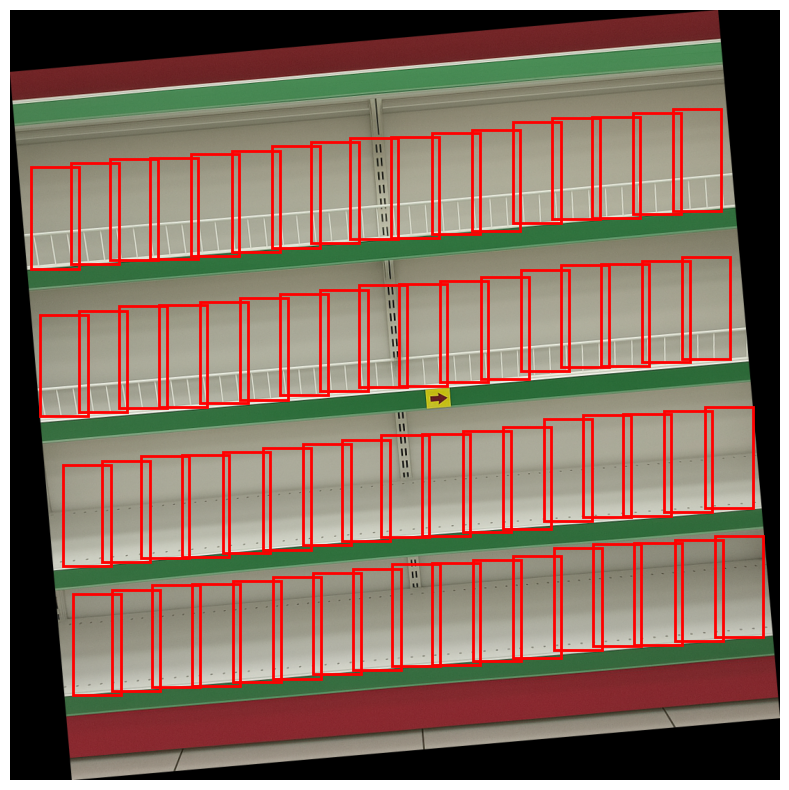

In [45]:
viz_utils.draw_boxes(rotated_img, rotated_boxes)

In [46]:
import cv2
import numpy as np

def flip_image_and_boxes_horizontally(image, boxes):
    """
    Horizontally flip image and bounding boxes.

    Parameters:
        image (np.ndarray): RGB image as NumPy array.
        boxes (list of tuples): List of (x_min, y_min, x_max, y_max) boxes.

    Returns:
        flipped_image (np.ndarray)
        flipped_boxes (list of tuples)
    """
    flipped_image = np.fliplr(image).copy()
    h, w = image.shape[:2]

    flipped_boxes = []
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        new_x_min = w - x_max
        new_x_max = w - x_min
        flipped_boxes.append((new_x_min, y_min, new_x_max, y_max))

    return flipped_image, flipped_boxes


In [47]:
flipped_img, flipped_boxes = flip_image_and_boxes_horizontally(background_img_np, background_boxes)

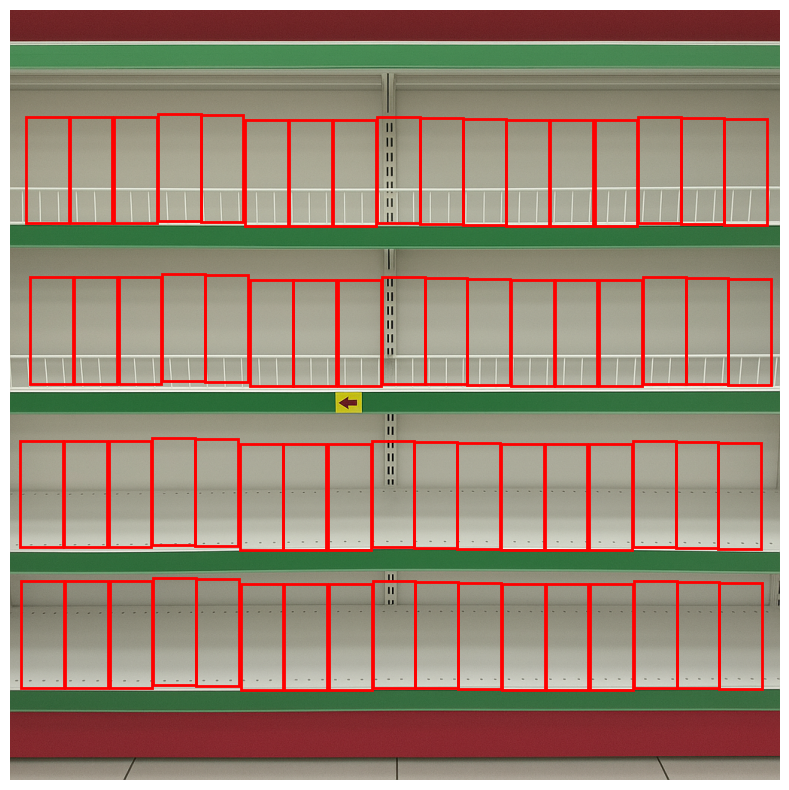

In [48]:
viz_utils.draw_boxes(flipped_img, flipped_boxes)

In [49]:
import numpy as np
import cv2
import random

def random_zoom(image, boxes, zoom_range=(0.8, 2.5)):
    h, w = image.shape[:2]
    zoom_factor = random.uniform(*zoom_range)

    new_w = int(w * zoom_factor)
    new_h = int(h * zoom_factor)

    # Resize image
    zoomed_image = cv2.resize(image, (new_w, new_h))
    zoomed_boxes = []

    if zoom_factor < 1.0:
        # Pad and center
        pad_w = (w - new_w) // 2
        pad_h = (h - new_h) // 2
        padded = np.zeros_like(image)
        padded[pad_h:pad_h + new_h, pad_w:pad_w + new_w] = zoomed_image
        zoomed_image = padded

        for box in boxes:
            x_min, y_min, x_max, y_max = box
            x_min = x_min * zoom_factor + pad_w
            x_max = x_max * zoom_factor + pad_w
            y_min = y_min * zoom_factor + pad_h
            y_max = y_max * zoom_factor + pad_h

            if x_min >= 0 and y_min >= 0 and x_max <= w and y_max <= h:
                zoomed_boxes.append((x_min, y_min, x_max, y_max))

    else:
        # Crop center
        crop_x = (new_w - w) // 2
        crop_y = (new_h - h) // 2
        zoomed_image = zoomed_image[crop_y:crop_y + h, crop_x:crop_x + w]

        for box in boxes:
            x_min, y_min, x_max, y_max = box
            x_min = x_min * zoom_factor - crop_x
            x_max = x_max * zoom_factor - crop_x
            y_min = y_min * zoom_factor - crop_y
            y_max = y_max * zoom_factor - crop_y

            if x_min >= 0 and y_min >= 0 and x_max <= w and y_max <= h:
                zoomed_boxes.append((x_min, y_min, x_max, y_max))

    return zoomed_image, zoomed_boxes


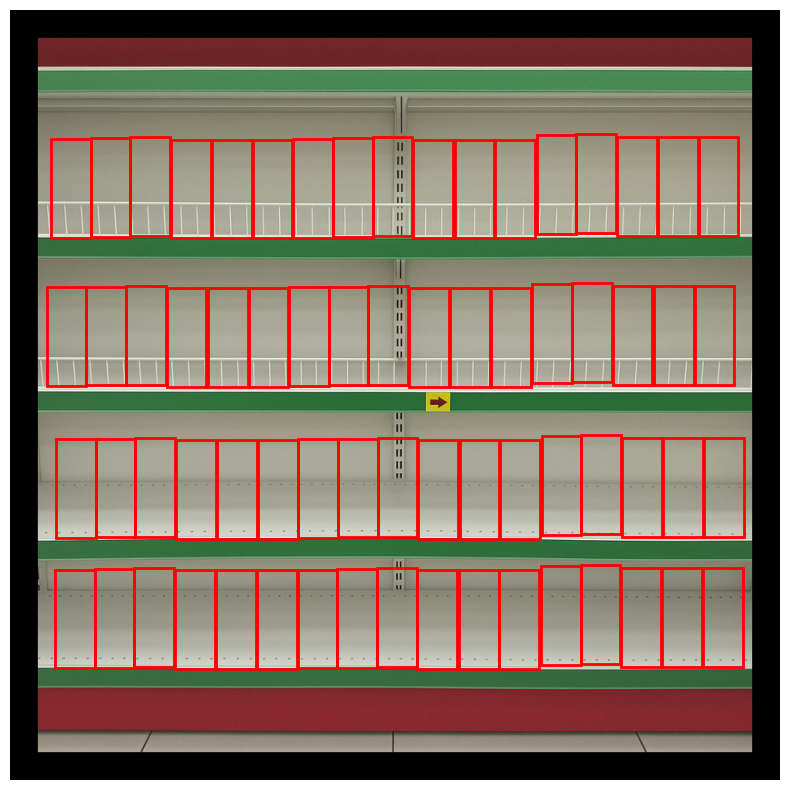

In [50]:
background_img_np = np.array(Image.open(background_img).convert("RGB"))
new_img, new_boxes = random_zoom(background_img_np, background_boxes)
viz_utils.draw_boxes(new_img, new_boxes)

In [51]:
import numpy as np
from hcmus.utils import viz_utils
from hcmus.data import AugmentTemplate

IndentationError: expected an indented block (_augment_template.py, line 131)

In [ ]:
augment_template = AugmentTemplate()

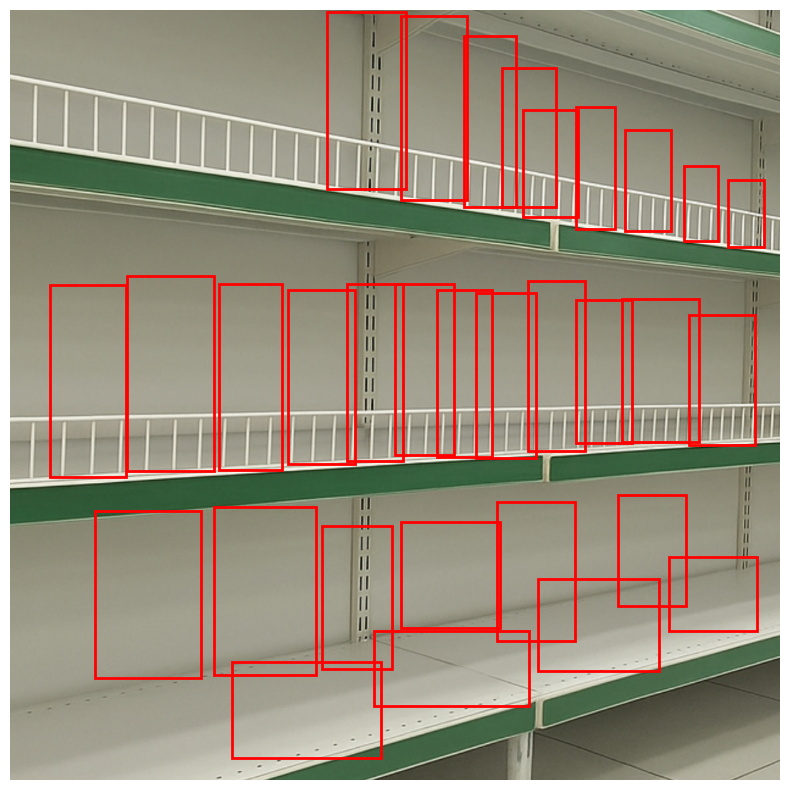

In [ ]:
idx = 2
image_path = dataset[idx].get("image")
image = np.array(Image.open(image_path).convert("RGB"))
boxes = dataset[idx].get("target").get("boxes")
new_image, new_boxes = augment_template.augment(image, boxes)
viz_utils.draw_boxes(new_image, new_boxes)

In [ ]:
import cv2
import numpy as np

def paste_object_smooth(background, object_img, top_left):
    x, y = top_left
    h, w = object_img.shape[:2]

    # Handle alpha channel if it exists
    if object_img.shape[2] == 4:
        object_rgb = object_img[:, :, :3]
        mask = object_img[:, :, 3]
    else:
        object_rgb = object_img
        mask = np.ones((h, w), dtype=np.uint8) * 255  # full opaque mask

    # Smooth the mask
    blurred_mask = cv2.GaussianBlur(mask, (21, 21), 0)
    alpha = blurred_mask.astype(float) / 255.0
    alpha = np.stack([alpha]*3, axis=-1)  # shape (h, w, 3)

    # Extract background patch
    bg_crop = background[y:y+h, x:x+w]

    # Handle boundary conditions (clip if object goes out of background)
    if bg_crop.shape[0] != h or bg_crop.shape[1] != w:
        h = min(h, background.shape[0] - y)
        w = min(w, background.shape[1] - x)
        object_rgb = object_rgb[:h, :w]
        alpha = alpha[:h, :w]
        bg_crop = background[y:y+h, x:x+w]

    # Blend object with background
    blended = (alpha * object_rgb + (1 - alpha) * bg_crop).astype(np.uint8)

    # Replace blended patch into background
    background[y:y+h, x:x+w] = blended

    return background

In [ ]:
lsb_connector_2 = LabelStudioConnector(
    url=appconfig.LABEL_STUDIO_URL,
    api_key=appconfig.LABEL_STUDIO_API_KEY,
    project_id=appconfig.LABEL_STUDIO_PROJECT_MAPPING["train"],
    temp_dir=appconfig.LABEL_STUDIO_TEMP_DIR
)

In [ ]:
tasks = lsb_connector_2.get_tasks()
dataset_2 = lsb_connector_2.download_dataset(tasks)

2025-05-04 15:30:58.693 | WARNING  | hcmus.lbs._label_studio_connector:get_tasks:121 - Page size is too large, only 1640 tasks available.
Loading tasks: 100%|██████████| 17/17 [00:04<00:00,  3.78it/s]
2025-05-04 15:31:03.201 | INFO     | hcmus.lbs._label_studio_connector:download_dataset:48 - No labels input, auto extract 209 labels.


In [ ]:
background = np.array(Image.open(dataset[1].get("image")))
object = Image.open(dataset_2[1].get("image"))
box = dataset_2[1].get("target").get("boxes")
object = np.array(viz_utils.crop_image(object, box)[0])

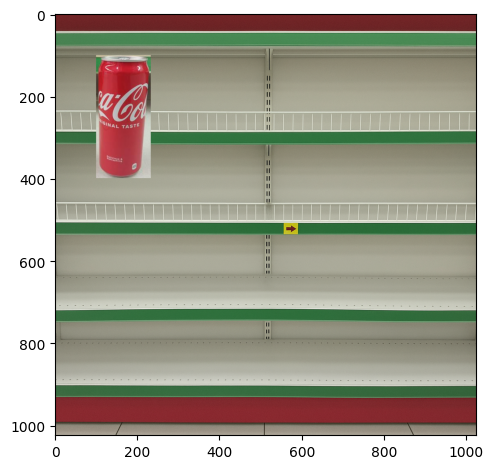

In [ ]:
viz_utils.plot_image(paste_object_smooth(background, object, (100, 100)))

In [58]:
import numpy as np
import random
import cv2
from typing import List, Tuple

def place(background: np.array, boxes: List[Tuple[int]], objects: List[np.array]) -> np.array:
    def match_brightness(obj_rgb, bg_patch):
        obj_mean = np.mean(obj_rgb)
        bg_mean = np.mean(bg_patch)
        factor = bg_mean / (obj_mean + 1e-6)
        return np.clip(obj_rgb * factor, 0, 255).astype(np.uint8)

    def random_rotate(img, max_angle=8):
        angle = random.uniform(-max_angle, max_angle)
        h, w = img.shape[:2]
        M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1.0)
        return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)

    def feather_alpha(obj, feather=5):
        if obj.shape[2] == 4:
            alpha = obj[:, :, 3].astype(np.float32) / 255
            alpha = cv2.GaussianBlur(alpha, (feather*2+1, feather*2+1), 0)
            obj[:, :, 3] = (alpha * 255).astype(np.uint8)
        return obj

    bg = background.copy()
    bg_h, bg_w = bg.shape[:2]

    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        bw, bh = x2 - x1, y2 - y1

        obj = random.choice(objects)
        obj = feather_alpha(obj.copy())
        obj = random_rotate(obj)

        oh, ow = obj.shape[:2]

        # Preserve aspect ratio: scale by the smaller fitting factor
        scale = min(bw / ow, bh / oh)
        new_w, new_h = max(1, int(ow * scale)), max(1, int(oh * scale))
        resized_obj = cv2.resize(obj, (new_w, new_h), interpolation=cv2.INTER_AREA)

        # Placement
        start_x = int(x1 + (bw - new_w) / 2)
        start_y = int(y1 + (bh - new_h) / 2)
        end_x, end_y = start_x + new_w, start_y + new_h

        if start_x < 0 or start_y < 0 or end_x > bg_w or end_y > bg_h:
            continue  # Skip if out of bounds

        # Match brightness with background patch
        bg_patch = bg[start_y:end_y, start_x:end_x]
        resized_obj_rgb = match_brightness(resized_obj[:, :, :3], bg_patch)

        if resized_obj.shape[2] == 4:
            alpha = resized_obj[:, :, 3].astype(np.float32) / 255.0
            for c in range(3):
                bg[start_y:end_y, start_x:end_x, c] = (
                    alpha * resized_obj_rgb[:, :, c] +
                    (1 - alpha) * bg[start_y:end_y, start_x:end_x, c]
                )
        else:
            bg[start_y:end_y, start_x:end_x] = resized_obj_rgb

    return bg


In [ ]:
idx = 2
background = np.array(Image.open(dataset[idx].get("image")))
boxes = dataset[idx].get("target").get("boxes")
objects = [(Image.open(x.get("image")), x.get("target").get("boxes")) for x in dataset_2[1:100]]
objects = [viz_utils.crop_image(x, b)[0] for (x, b) in objects]
objects = [np.array(x) for x in objects]

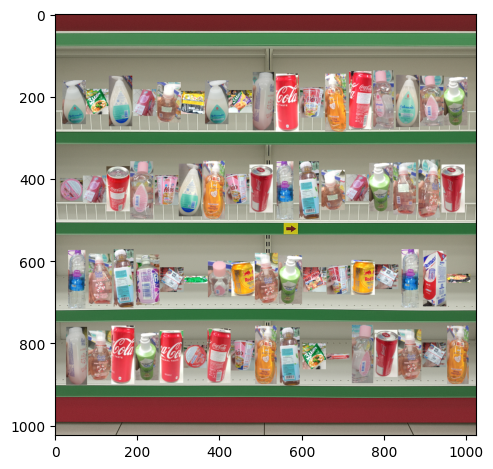

In [ ]:
viz_utils.plot_image(place(background, boxes, objects))

### Use U2Net

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import numpy as np
import cv2
import random
from typing import List, Tuple
from PIL import Image

# Load U^2-Net from Hugging Face
model = keras.saving.load_model("hf://reidn3r/u2net-image-rembg")


Fetching 7 files: 100%|██████████| 7/7 [00:00<00:00, 68120.95it/s]


In [ ]:
def segment_with_u2net_keras(obj_img: np.ndarray) -> np.ndarray:
    img = cv2.cvtColor(obj_img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (512, 512))
    img_norm = img_resized / 255.0

    # Model expects shape (1, 320, 320, 3)
    input_tensor = np.expand_dims(img_norm, axis=0).astype(np.float32)

    # Predict alpha matte
    pred = model(input_tensor, training=False)
    if isinstance(pred, list):
        pred = pred[0]
    pred = pred.numpy()[0, :, :, 0]
    pred = cv2.resize(pred, (obj_img.shape[1], obj_img.shape[0]))

    # Normalize and convert to 0-255 alpha
    alpha = (pred * 255).astype(np.uint8)

    # Compose RGBA
    rgba = cv2.cvtColor(obj_img, cv2.COLOR_BGR2BGRA)
    rgba[:, :, 3] = alpha
    return rgba


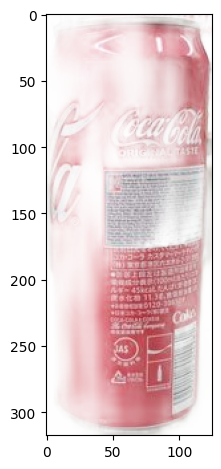

In [ ]:
viz_utils.plot_image(segment_with_u2net_keras(objects[4]))

In [52]:
new_objects = [segment_with_u2net_keras(x) for x in objects]

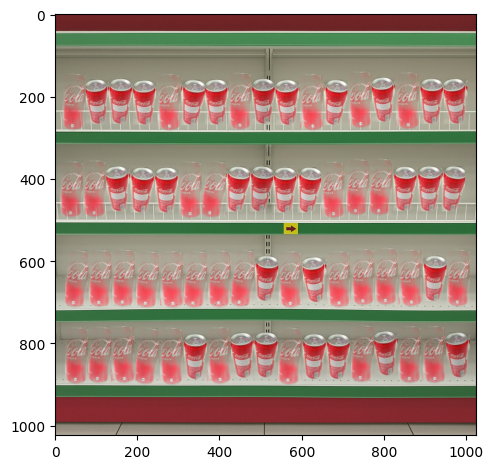

In [63]:
viz_utils.plot_image(place(background, boxes, new_objects[0:2]))

In [ ]:
import torch
from transformers import AutoImageProcessor, MobileNetV2ForSemanticSegmentation

# Load model and processor once
processor = AutoImageProcessor.from_pretrained("google/deeplabv3_mobilenet_v2_1.0_513")
model = MobileNetV2ForSemanticSegmentation.from_pretrained("google/deeplabv3_mobilenet_v2_1.0_513")

def remove_background(image_path: str, target_class: int = 15):
    """
    Removes background from an image using semantic segmentation.

    Args:
        image_path (str): Path to the input image.
        output_path (str): Path to save the output image.
        target_class (int): Class index to keep. 15 = person (COCO format).

    Returns:
        None (saves the output image to output_path)
    """
    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits  # [1, num_classes, height, width]
    upsampled_logits = torch.nn.functional.interpolate(
        logits,
        size=image.size[::-1],  # (height, width)
        mode="bilinear",
        align_corners=False
    )

    predicted_classes = upsampled_logits.argmax(1)[0].cpu().numpy()

    # Create mask: only keep pixels where predicted class == target_class (person = 15 in COCO)
    mask = (predicted_classes == target_class).astype(np.uint8) * 255

    # Convert original image to numpy
    image_np = np.array(image)

    # Apply mask
    masked_image = cv2.bitwise_and(image_np, image_np, mask=mask)

    # Convert to RGBA with transparent background
    b, g, r = cv2.split(masked_image)
    alpha = mask
    rgba = cv2.merge((b, g, r, alpha))

    # Save result
    cv2.imwrite(output_path, rgba)
    print(f"Saved image with background removed: {output_path}")

In [67]:
from transformers import AutoImageProcessor, AutoModelForSemanticSegmentation
from PIL import Image

image = Image.open(dataset_2[0].get("image"))

preprocessor = AutoImageProcessor.from_pretrained("google/deeplabv3_mobilenet_v2_1.0_513")
model = AutoModelForSemanticSegmentation.from_pretrained("google/deeplabv3_mobilenet_v2_1.0_513")

inputs = preprocessor(images=image, return_tensors="pt")

outputs = model(**inputs)
predicted_mask = preprocessor.post_process_semantic_segmentation(outputs)


In [ ]:
predicted_mask[0].numpy()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])